In [1]:
import pandas as pd
import pylab
import matplotlib.pyplot as plt

import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

### use case

1) large number of x variables
2) most of which contain little info
3) some of which are meaningful
4) meaningful variables are independent of each other

### possible solution

1) variance thresholding
2) chi-square feature selection (used for categorical variables)
3) ANOVA (check whether the mean of y varies with the mean of X)
4) mutual information (conceptually similar to ANOVA, superior as it captures non-linear relationship)

### Univariate feature selection

In [2]:
housesale_df = pd.read_csv('kc_house_data.csv')
housesale_df.dropna(inplace=True)
housesale_df.reset_index(inplace=True)
housesale_df.head()

X = housesale_df.drop(['price', 'id', 'date'], axis=1)
y = housesale_df['price']

print (X.shape)

(21611, 19)


In [3]:
select_features = SelectKBest(f_regression, k=3)
X_new = select_features.fit_transform(X, y)
X_new = pd.DataFrame(X_new)
print (X_new.shape)

(21611, 3)


In [4]:
selected_features = []

for i in range(len(X_new.columns)):
    for j in range(len(X.columns)):
        if (X.iloc[:, j].values == X_new.iloc[:, i]).all():
            selected_features.append(X.columns[j])

rejected_features = set(list(X)) - set(selected_features)
selected_features

['sqft_living', 'grade', 'sqft_above']

In [5]:
x_train, x_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2)
print(x_train.shape, y_train.shape)

model = sm.OLS(y_train, x_train)
result = model.fit()
print(result.summary())

(17288, 3) (17288,)
                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.841
Model:                            OLS   Adj. R-squared (uncentered):              0.841
Method:                 Least Squares   F-statistic:                          3.047e+04
Date:                Wed, 21 Oct 2020   Prob (F-statistic):                        0.00
Time:                        11:24:17   Log-Likelihood:                     -2.4004e+05
No. Observations:               17288   AIC:                                  4.801e+05
Df Residuals:                   17285   BIC:                                  4.801e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------

In [6]:
FEATURES = list(X.columns[1:20])

In [7]:
def build_model(regression_fn,
                target,
                features,
                dataset,
                preprocess_fn,
                *hyperparameters):
    
    X = dataset[features]
    Y = dataset[target]
    
    X = preprocess_fn(X, Y, *hyperparameters)
    
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    
    model = regression_fn(x_train, y_train)
    
    y_pred = model.predict(x_test)
    
    return {
        'x_train': x_train,
        'x_test': x_test,
        'y_train': y_train,
        'y_test': y_test,
        'y_pred': y_pred,
        'model': model
    }

In [8]:
def compare_results(result_dict):
    
    for key in result_dict:
        print('Test: ', key)
        print('R-squared: ', result_dict[key]['rsquared'])
        print('Adjusted R-squared: ', result_dict[key]['adj_rsquared'])
        print()
        
    n_components = list(range(1, 20))
    reg_score = [result_dict[key]['adj_rsquared'] for key in result_dict]
    
    plt.figure(figsize=(12, 10))
    plt.plot(n_components, reg_score)
    
    pylab.ylim([0, 1])
    
    plt.xlabel('n components')
    plt.ylabel('adj_rsquared')

In [9]:
def get_model_scores(model_params):
    
    result_dict = {}
    
    for key in model_params:
        result_dict[key] = {
            'rsquared': model_params[key]['model'].rsquared,
            'adj_rsquared': model_params[key]['model'].rsquared_adj
        }
    compare_results(result_dict)

In [10]:
def ols_reg(x_train, y_train):
    
    ols = sm.OLS(y_train, x_train)
    
    model = ols.fit()
    
    return model

In [11]:
def apply_f_regression(x, y, k, add_constant=False):
    
    select_features = SelectKBest(f_regression, k=k)
    x_new = select_features.fit_transform(x, y)
    
    if add_constant:
        x_new = sm.add_constant(x_new)
    
    return pd.DataFrame(x_new)

In [12]:
model_params = {}

for i in range(1, 19):
    model_params['f_regression - k:' + str(i)] = build_model(ols_reg, 
                                                             'price', 
                                                              FEATURES, 
                                                              housesale_df, 
                                                              apply_f_regression,
                                                              i,
                                                              True)

Test:  f_regression - k:1
R-squared:  0.49241938176792577
Adjusted R-squared:  0.49239001808527894

Test:  f_regression - k:2
R-squared:  0.5341510890598671
Adjusted R-squared:  0.5340971869585145

Test:  f_regression - k:3
R-squared:  0.544796030849821
Adjusted R-squared:  0.5447170206723475

Test:  f_regression - k:4
R-squared:  0.5438626005920995
Adjusted R-squared:  0.5437570315590825

Test:  f_regression - k:5
R-squared:  0.546465150365874
Adjusted R-squared:  0.5463339344042856

Test:  f_regression - k:6
R-squared:  0.5771392286205348
Adjusted R-squared:  0.5769924104602271

Test:  f_regression - k:7
R-squared:  0.5799967775938577
Adjusted R-squared:  0.5798509515806387

Test:  f_regression - k:8
R-squared:  0.579929504691225
Adjusted R-squared:  0.5797593372452086

Test:  f_regression - k:9
R-squared:  0.6420578700461739
Adjusted R-squared:  0.6418921465066385

Test:  f_regression - k:10
R-squared:  0.662034063924311
Adjusted R-squared:  0.6618580196237738

Test:  f_regression -

ValueError: x and y must have same first dimension, but have shapes (19,) and (18,)

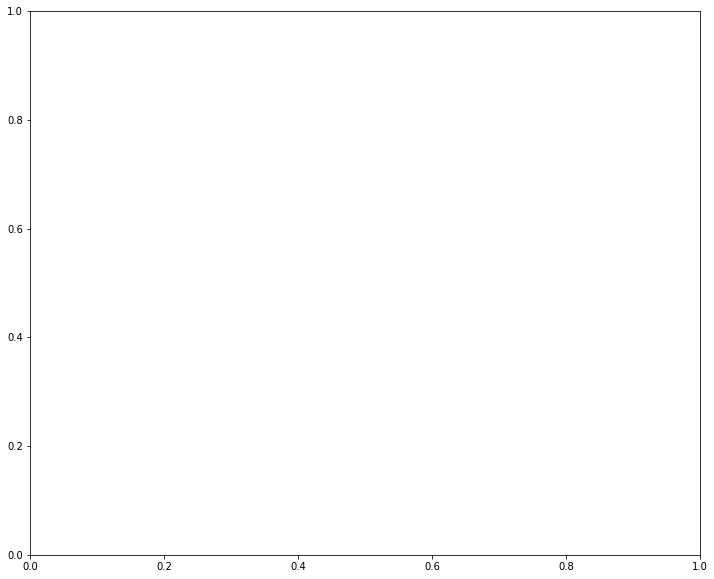

In [13]:
get_model_scores(model_params)

In [14]:
def linear_reg(x_train, y_train):
    
    model = LinearRegression().fit(x_train, y_train)
    
    return model

In [15]:
sklearn_model = {}

sklearn_model['f_regression'] = build_model(linear_reg, 'price', FEATURES, housesale_df, apply_f_regression, 10)

In [16]:
regression_fn = ols_reg
target = 'price'
features = FEATURES
dataset = housesale_df
preprocess_fn = apply_f_regression

    
X = dataset[features]
Y = dataset[target]

X = preprocess_fn(X, Y, 0, True)
    
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

model = regression_fn(x_train, y_train)

y_pred = model.predict(x_test)

ds =  {
    'x_train': x_train,
    'x_test': x_test,
    'y_train': y_train,
    'y_test': y_test,
    'y_pred': y_pred,
    'model': model
}

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\base.py:79: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  UserWarning)


In [17]:
model = sklearn_model['f_regression']['model']
x_train = sklearn_model['f_regression']['x_train']
x_test = sklearn_model['f_regression']['x_test']
y_train = sklearn_model['f_regression']['y_train']
y_test = sklearn_model['f_regression']['y_test']
y_pred = sklearn_model['f_regression']['y_pred']

In [18]:
print('Training scores: ', model.score(x_train, y_train))
print('Testing scores: ', r2_score(y_test, y_pred))

Training scores:  0.6511708589524776
Testing scores:  0.680682476329106


### Mutual information

In [19]:
def apply_mutual_info_regression(x, y, k, add_constant=False):
    
    select_features = SelectKBest(mutual_info_regression, k=k)
    x_new = select_features.fit_transform(x, y)
    
    if add_constant:
        x_new = sm.add_constant(x_new)
        
    return pd.DataFrame(x_new)

In [20]:
model_params = {}

for i in range(1, 19):
    model_params['f_regression - k:' + str(i)] = build_model(ols_reg, 
                                                             'price', 
                                                              FEATURES, 
                                                              housesale_df, 
                                                              apply_mutual_info_regression,
                                                              i,
                                                              True)

Test:  f_regression - k:1
R-squared:  0.0023008556262494873
Adjusted R-squared:  0.002243138447933224

Test:  f_regression - k:2
R-squared:  0.499012610083596
Adjusted R-squared:  0.49895464220509833

Test:  f_regression - k:3
R-squared:  0.5482991722463793
Adjusted R-squared:  0.5482207701124253

Test:  f_regression - k:4
R-squared:  0.597328158459902
Adjusted R-squared:  0.5972349635651406

Test:  f_regression - k:5
R-squared:  0.603450032769485
Adjusted R-squared:  0.6033353035809563

Test:  f_regression - k:6
R-squared:  0.5955873205170663
Adjusted R-squared:  0.5954469075735505

Test:  f_regression - k:7
R-squared:  0.6008680968270282
Adjusted R-squared:  0.6007064114495855

Test:  f_regression - k:8
R-squared:  0.6123271380632596
Adjusted R-squared:  0.6121476494993673

Test:  f_regression - k:9
R-squared:  0.624189929288708
Adjusted R-squared:  0.623994172219811

Test:  f_regression - k:10
R-squared:  0.6152947864846665
Adjusted R-squared:  0.6150721174949603

Test:  f_regressio

ValueError: x and y must have same first dimension, but have shapes (19,) and (18,)

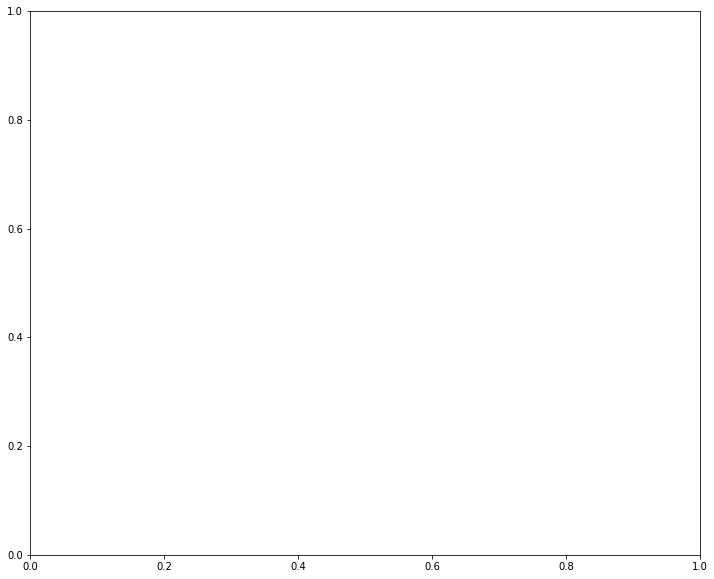

In [21]:
get_model_scores(model_params)

In [ ]:
sklearn_model = {}

sklearn_model['f_regression'] = build_model(linear_reg, 'price', FEATURES, housesale_df, apply_f_regression, 10)